In [ ]:

!pip -q install gradio==4.44.1

import os
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
CSV_PATH = "full_data.csv"
assert os.path.exists(CSV_PATH), f"{CSV_PATH} bulunamadı. Colab'a yüklediğinden emin ol."

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.tail())
print(df.dtypes)


In [ ]:
def find_time_column(columns):
    # isim bazlı adaylar
    candidates = []
    for c in columns:
        lc = c.lower()
        if any(k in lc for k in ["date", "time", "timestamp", "datetime", "tarih", "saat"]):
            candidates.append(c)
    return candidates[0] if candidates else None

def find_target_column(df):
    # isim bazlı öncelikler
    preferred_keywords = ["consumption", "demand", "load", "energy", "tuketim", "tüketim"]
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in preferred_keywords):
            if pd.api.types.is_numeric_dtype(df[c]):
                return c

    # isim tutmadıysa: numerikler içinde en anlamlı varyansa sahip olanı seç
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        return None
    variances = {c: float(np.nanvar(df[c].values)) for c in numeric_cols}
    return max(variances, key=variances.get)

time_col = find_time_column(df.columns)
target_col = find_target_column(df)

print("Bulunan zaman sütunu:", time_col)
print("Bulunan hedef sütun:", target_col)

if time_col is None:
    print("\n⚠️ Zaman sütunu otomatik bulunamadı.")
    print("Sütunlar:", list(df.columns))
    print("Bu durumda time_col değişkenini elle set etmen gerekebilir.")
if target_col is None:
    print("\n⚠️ Hedef sütun otomatik bulunamadı (numeric kolon yok).")


In [ ]:
if time_col is not None:
    # parse (hata varsa NaT olur)
    df[time_col] = pd.to_datetime(df[time_col], errors="coerce", infer_datetime_format=True)
    df = df.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

# hedefi temizle
df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
df = df.dropna(subset=[target_col]).reset_index(drop=True)

print("Temizlik sonrası shape:", df.shape)
display(df[[time_col, target_col]].head() if time_col else df[[target_col]].head())


In [15]:
# HÜCRE A – Ham veriyi tekrar oku
import pandas as pd
import numpy as np

CSV_PATH = "full_data.csv"
raw = pd.read_csv(CSV_PATH)

print("RAW shape:", raw.shape)
print("Columns:", list(raw.columns))

col = "consumption_MWh"
if col in raw.columns:
    print("\nRaw target sample:")
    display(raw[col].head(10))
    print("\nRaw target dtype:", raw[col].dtype)


RAW shape: (52584, 22)
Columns: ['time', 'consumption_MWh', 'total_generation_MWh', 'natural_gas', 'hydro_dam', 'lignite', 'hydro_river', 'coal_imported', 'wind', 'solar', 'fuel_oil', 'geothermal', 'asphaltite_coal', 'hard_coal', 'biomass', 'naphtha', 'LNG', 'international', 'waste_heat', 'TRY/MWh', 'USD/MWh', 'EUR/MWh']

Raw target sample:


,consumption_MWh
0,27412.81
1,26324.39
2,24635.32
3,23872.12
4,23194.89
5,23071.96
6,23267.90
7,23875.44
8,24346.96
9,25804.69



Raw target dtype: float64


In [16]:
# HÜCRE B – Robust numeric dönüşüm
def to_float_robust(s: pd.Series) -> pd.Series:
    x = s.astype(str).str.strip()
    x = x.replace({"": np.nan, "None": np.nan, "nan": np.nan, "NaN": np.nan})
    x = x.str.replace(r"[^\d\.,\-]", "", regex=True)

    both = x.str.contains(r"\.") & x.str.contains(r",")
    x.loc[both] = x.loc[both].str.replace(".", "", regex=False).str.replace(",", ".", regex=False)

    only_comma = x.str.contains(",") & (~x.str.contains(r"\."))
    x.loc[only_comma] = x.loc[only_comma].str.replace(",", ".", regex=False)

    return pd.to_numeric(x, errors="coerce")

raw["consumption_MWh_num"] = to_float_robust(raw["consumption_MWh"])

print("Non-NaN after robust parse:", raw["consumption_MWh_num"].notna().sum())
display(raw[["consumption_MWh", "consumption_MWh_num"]].head(15))


Non-NaN after robust parse: 52584


,consumption_MWh,consumption_MWh_num
0,27412.81,27412.81
1,26324.39,26324.39
2,24635.32,24635.32
3,23872.12,23872.12
4,23194.89,23194.89
5,23071.96,23071.96
6,23267.90,23267.90
7,23875.44,23875.44
8,24346.96,24346.96
9,25804.69,25804.69


In [17]:
# HÜCRE C – Zamanı güvenli parse et
def find_time_column(columns):
    for c in columns:
        lc = c.lower()
        if any(k in lc for k in ["date", "time", "timestamp", "datetime", "tarih", "saat"]):
            return c
    return None

time_col = find_time_column(raw.columns)
print("time_col:", time_col)

raw["time_parsed"] = pd.to_datetime(
    raw[time_col],
    errors="coerce",
    infer_datetime_format=True
) if time_col else pd.NaT

print("Parse edilebilen time sayısı:", raw["time_parsed"].notna().sum())

df2 = raw.dropna(subset=["time_parsed", "consumption_MWh_num"]).copy()
df2 = df2.sort_values("time_parsed").reset_index(drop=True)

print("df2 shape:", df2.shape)
display(df2[["time_parsed", "consumption_MWh_num"]].head())


time_col: time


/tmp/ipython-input-1647815953.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw["time_parsed"] = pd.to_datetime(
/tmp/ipython-input-1647815953.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw["time_parsed"] = pd.to_datetime(


Parse edilebilen time sayısı: 0
df2 shape: (0, 24)


,time_parsed,consumption_MWh_num


In [18]:
print("time dtype:", raw["time"].dtype)
display(raw["time"].head(20))
print("\nUnique sample:")
print(raw["time"].astype(str).head(5).tolist())


time dtype: object


,time
0,01:01:2018:00:00
1,01:01:2018:01:00
2,01:01:2018:02:00
3,01:01:2018:03:00
4,01:01:2018:04:00
5,01:01:2018:05:00
6,01:01:2018:06:00
7,01:01:2018:07:00
8,01:01:2018:08:00
9,01:01:2018:09:00



Unique sample:
['01:01:2018:00:00', '01:01:2018:01:00', '01:01:2018:02:00', '01:01:2018:03:00', '01:01:2018:04:00']


In [21]:
import pandas as pd

time_str = raw["time"].astype(str).str.strip()

# Senin formatın: DD:MM:YYYY:HH:MM  ->  %d:%m:%Y:%H:%M
raw["time_parsed"] = pd.to_datetime(time_str, format="%d:%m:%Y:%H:%M", errors="coerce")

print("Parsed count:", raw["time_parsed"].notna().sum(), "/", len(raw))

# df2 oluştur
df2 = raw.dropna(subset=["time_parsed", "consumption_MWh_num"]).copy()
df2 = df2.sort_values("time_parsed").reset_index(drop=True)

print("df2 shape:", df2.shape)
display(df2[["time_parsed", "consumption_MWh_num"]].head())
display(df2[["time_parsed", "consumption_MWh_num"]].tail())


Parsed count: 52584 / 52584
df2 shape: (52584, 24)


,time_parsed,consumption_MWh_num
0,2018-01-01 00:00:00,27412.81
1,2018-01-01 01:00:00,26324.39
2,2018-01-01 02:00:00,24635.32
3,2018-01-01 03:00:00,23872.12
4,2018-01-01 04:00:00,23194.89


,time_parsed,consumption_MWh_num
52579,2023-12-31 19:00:00,35090.93
52580,2023-12-31 20:00:00,33310.94
52581,2023-12-31 21:00:00,32083.96
52582,2023-12-31 22:00:00,30469.49
52583,2023-12-31 23:00:00,30029.91


In [28]:
# df'yi sıfırla (varsa sil)
try:
    del df
except NameError:
    pass

print("df silindi (varsa).")


df silindi (varsa).


In [29]:
print("df2 columns:", df2.columns.tolist())


df2 columns: ['time', 'consumption_MWh', 'total_generation_MWh', 'natural_gas', 'hydro_dam', 'lignite', 'hydro_river', 'coal_imported', 'wind', 'solar', 'fuel_oil', 'geothermal', 'asphaltite_coal', 'hard_coal', 'biomass', 'naphtha', 'LNG', 'international', 'waste_heat', 'TRY/MWh', 'USD/MWh', 'EUR/MWh', 'consumption_MWh_num', 'time_parsed']


In [30]:
df = df2.loc[:, ["time_parsed", "consumption_MWh_num"]].copy()
df.columns = ["time", "target"]   # yeniden adlandır

print("df shape:", df.shape)
print(df.dtypes)
display(df.head())


df shape: (52584, 2)
time      datetime64[ns]
target           float64
dtype: object


,time,target
0,2018-01-01 00:00:00,27412.81
1,2018-01-01 01:00:00,26324.39
2,2018-01-01 02:00:00,24635.32
3,2018-01-01 03:00:00,23872.12
4,2018-01-01 04:00:00,23194.89


In [33]:
import numpy as np

# split
values = df["target"].values.astype(np.float32)
n = len(values)

train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_raw = values[:train_end]
val_raw   = values[train_end:val_end]
test_raw  = values[val_end:]

print("Lengths -> train/val/test:", len(train_raw), len(val_raw), len(test_raw))

# scale (scaler zaten fit edilmemişse burada fit et)
scaler = MinMaxScaler1D().fit(train_raw)
train = scaler.transform(train_raw)
val   = scaler.transform(val_raw)
test  = scaler.transform(test_raw)

SEQ_LEN = 24

def create_sequences(series, seq_len=24):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = create_sequences(train, SEQ_LEN)
X_val, y_val     = create_sequences(val, SEQ_LEN)
X_test, y_test   = create_sequences(test, SEQ_LEN)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


Lengths -> train/val/test: 36808 7888 7888
X_train: (36784, 24) y_train: (36784,)
X_val  : (7864, 24) y_val  : (7864,)
X_test : (7864, 24) y_test : (7864,)


In [ ]:
plt.figure()
plt.plot(df[target_col].values)
plt.title(f"Target Series: {target_col}")
plt.xlabel("Index (time order)")
plt.ylabel(target_col)
plt.show()


In [23]:
# ZAMANA GÖRE TRAIN / VAL / TEST SPLIT
values = df["target"].values.astype(np.float32)

n = len(values)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_raw = values[:train_end]
val_raw   = values[train_end:val_end]
test_raw  = values[val_end:]

print("Lengths -> train / val / test:")
print(len(train_raw), len(val_raw), len(test_raw))


Lengths -> train / val / test:
36808 7888 7888


In [25]:
class MinMaxScaler1D:
    def __init__(self):
        self.min_ = None
        self.max_ = None

    def fit(self, x):
        self.min_ = float(np.min(x))
        self.max_ = float(np.max(x))
        if self.max_ - self.min_ < 1e-12:
            self.max_ = self.min_ + 1e-12
        return self

    def transform(self, x):
        return (x - self.min_) / (self.max_ - self.min_)

    def inverse_transform(self, x):
        return x * (self.max_ - self.min_) + self.min_

scaler = MinMaxScaler1D().fit(train_raw)
train = scaler.transform(train_raw)
val   = scaler.transform(val_raw)
test  = scaler.transform(test_raw)

print("Scaled ranges:", train.min(), train.max())


Scaled ranges: 0.0 1.0


In [54]:
SEQ_LEN = 24  # son 24 adım -> 1 adım ileri tahmin (saatlikse 1 gün penceresi mantıklı)

def create_sequences(series, seq_len=24):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

X_train, y_train = create_sequences(train, SEQ_LEN)
X_val, y_val     = create_sequences(val, SEQ_LEN)
X_test, y_test   = create_sequences(test, SEQ_LEN)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (36784, 24) y_train: (36784,)
X_val: (7864, 24) y_val: (7864,)
X_test: (7864, 24) y_test: (7864,)


In [53]:
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(-1)  # (N, seq, 1)
        self.y = torch.tensor(y).unsqueeze(-1)  # (N, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 128

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(SeqDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(SeqDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [52]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)         # (B, seq, hidden)
        out = out[:, -1, :]           # last time step
        out = self.fc(out)            # (B, 1)
        return out

model = LSTMForecast(hidden_size=64, num_layers=1).to(device)
model


LSTMForecast(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [51]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    losses = []
    criterion = nn.MSELoss()

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            pred = model(Xb)
            loss = criterion(pred, yb)
            if is_train:
                loss.backward()
                optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
patience = 7
best_val = float("inf")
pat_cnt = 0
best_path = "lstm_model.pth"

train_hist, val_hist = [], []

for epoch in range(1, EPOCHS+1):
    tr_loss = run_epoch(model, train_loader, optimizer)
    va_loss = run_epoch(model, val_loader, optimizer=None)
    train_hist.append(tr_loss)
    val_hist.append(va_loss)

    print(f"Epoch {epoch:02d} | train MSE: {tr_loss:.6f} | val MSE: {va_loss:.6f}")

    if va_loss < best_val - 1e-6:
        best_val = va_loss
        pat_cnt = 0
        torch.save(model.state_dict(), best_path)
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("Early stopping.")
            break

print("Best val MSE:", best_val)


Epoch 01 | train MSE: 0.000167 | val MSE: 0.000178
Epoch 02 | train MSE: 0.000165 | val MSE: 0.000170
Epoch 03 | train MSE: 0.000162 | val MSE: 0.000172
Epoch 04 | train MSE: 0.000164 | val MSE: 0.000195
Epoch 05 | train MSE: 0.000160 | val MSE: 0.000172
Epoch 06 | train MSE: 0.000156 | val MSE: 0.000185
Epoch 07 | train MSE: 0.000152 | val MSE: 0.000172
Epoch 08 | train MSE: 0.000153 | val MSE: 0.000159
Epoch 09 | train MSE: 0.000152 | val MSE: 0.000152
Epoch 10 | train MSE: 0.000149 | val MSE: 0.000181
Epoch 11 | train MSE: 0.000149 | val MSE: 0.000149
Epoch 12 | train MSE: 0.000144 | val MSE: 0.000155
Epoch 13 | train MSE: 0.000144 | val MSE: 0.000154
Epoch 14 | train MSE: 0.000145 | val MSE: 0.000188
Epoch 15 | train MSE: 0.000143 | val MSE: 0.000150
Epoch 16 | train MSE: 0.000142 | val MSE: 0.000164
Epoch 17 | train MSE: 0.000139 | val MSE: 0.000146
Epoch 18 | train MSE: 0.000138 | val MSE: 0.000173
Epoch 19 | train MSE: 0.000142 | val MSE: 0.000149
Epoch 20 | train MSE: 0.000137 

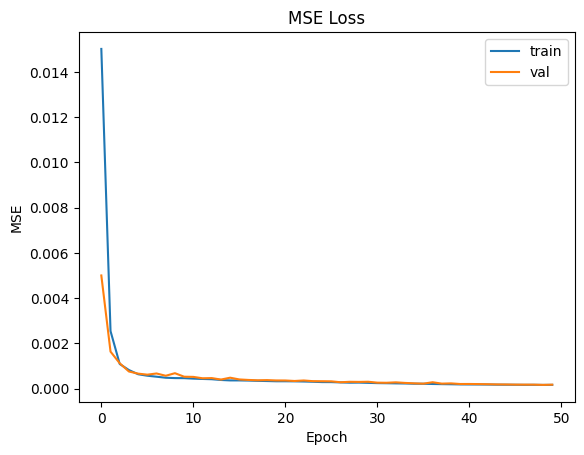

In [50]:
plt.figure()
plt.plot(train_hist, label="train")
plt.plot(val_hist, label="val")
plt.title("MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [49]:
# en iyi modeli yükle
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

def predict_all(model, loader):
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            pred = model(Xb).cpu().numpy().reshape(-1)
            true = yb.numpy().reshape(-1)
            preds.append(pred)
            trues.append(true)
    return np.concatenate(preds), np.concatenate(trues)

pred_scaled, true_scaled = predict_all(model, test_loader)

# ölçek geri al
pred = scaler.inverse_transform(pred_scaled)
true = scaler.inverse_transform(true_scaled)

mae = float(np.mean(np.abs(pred - true)))
rmse = float(np.sqrt(np.mean((pred - true)**2)))
mape = float(np.mean(np.abs((pred - true) / (true + 1e-8))) * 100)

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE : 406.2179
RMSE: 560.2155
MAPE: 1.12%


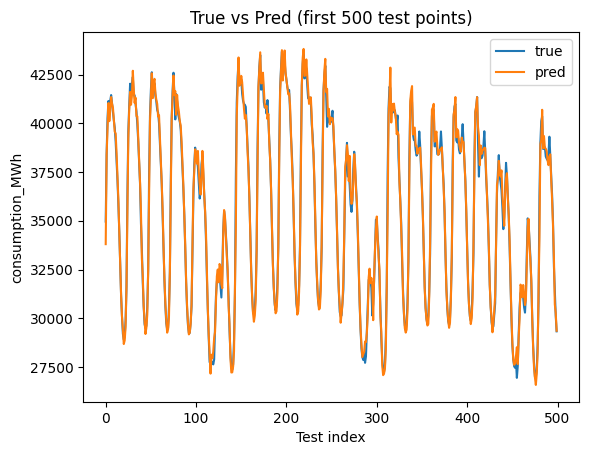

In [48]:
plt.figure()
plt.plot(true[:500], label="true")
plt.plot(pred[:500], label="pred")
plt.title("True vs Pred (first 500 test points)")
plt.xlabel("Test index")
plt.ylabel(target_col)
plt.legend()
plt.show()


In [47]:
# naive baseline: y_hat(t) = y(t-1)
# test set sequence yapısı nedeniyle true_scaled ile aynı uzunlukta naive üretelim:
# true_scaled: t+1 hedefleri, naive: bir önceki zaman adımı
test_series_scaled = test  # ölçekli test serisi
_, y_test_scaled = create_sequences(test_series_scaled, SEQ_LEN)
# naive tahmini: her hedef için bir önceki değer -> pencerenin son elemanı
X_test_scaled, _ = create_sequences(test_series_scaled, SEQ_LEN)
naive_scaled = X_test_scaled[:, -1]  # pencerenin sonu

naive = scaler.inverse_transform(naive_scaled)
true2 = scaler.inverse_transform(y_test_scaled)

mae_n = float(np.mean(np.abs(naive - true2)))
rmse_n = float(np.sqrt(np.mean((naive - true2)**2)))
mape_n = float(np.mean(np.abs((naive - true2) / (true2 + 1e-8))) * 100)

print("Baseline (Naive) metrics")
print(f"MAE : {mae_n:.4f}")
print(f"RMSE: {rmse_n:.4f}")
print(f"MAPE: {mape_n:.2f}%")

print("\nLSTM vs Naive (lower is better)")
print(f"MAE : {mae:.4f} vs {mae_n:.4f}")
print(f"RMSE: {rmse:.4f} vs {rmse_n:.4f}")
print(f"MAPE: {mape:.2f}% vs {mape_n:.2f}%")


Baseline (Naive) metrics
MAE : 1152.5505
RMSE: 1527.3179
MAPE: 3.14%

LSTM vs Naive (lower is better)
MAE : 406.2179 vs 1152.5505
RMSE: 560.2155 vs 1527.3179
MAPE: 1.12% vs 3.14%


In [45]:
artifacts_dir = "artifacts"
os.makedirs(artifacts_dir, exist_ok=True)

# model zaten best_path'e kaydedildi; onu artifacts içine kopyalayalım
final_model_path = os.path.join(artifacts_dir, "lstm_model.pth")
torch.save(model.state_dict(), final_model_path)

scaler_path = os.path.join(artifacts_dir, "scaler.json")
with open(scaler_path, "w", encoding="utf-8") as f:
    json.dump({"min": scaler.min_, "max": scaler.max_, "seq_len": SEQ_LEN, "target_col": target_col}, f, ensure_ascii=False, indent=2)

print("Saved:")
print("-", final_model_path)
print("-", scaler_path)


Saved:
- artifacts/lstm_model.pth
- artifacts/scaler.json


In [46]:
import gradio as gr

# inference için model + scaler tekrar hazır
infer_model = LSTMForecast(hidden_size=64, num_layers=1).to(device)
infer_model.load_state_dict(torch.load(final_model_path, map_location=device))
infer_model.eval()

def forecast_next(values_csv: str):
    try:
        parts = [float(x.strip()) for x in values_csv.split(",") if x.strip() != ""]
        if len(parts) != SEQ_LEN:
            return f"Hata: {SEQ_LEN} adet değer girmelisin. Sen {len(parts)} girdin."

        arr = np.array(parts, dtype=np.float32)
        arr_scaled = scaler.transform(arr)

        x = torch.tensor(arr_scaled, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # (1, seq, 1)
        with torch.no_grad():
            pred_scaled = infer_model(x).cpu().numpy().reshape(-1)[0]
        pred = float(scaler.inverse_transform(pred_scaled))
        return f"Tahmin edilen bir sonraki tüketim: {pred:.4f}"
    except Exception as e:
        return f"Hata: {str(e)}"

demo = gr.Interface(
    fn=forecast_next,
    inputs=gr.Textbox(lines=2, placeholder=f"{SEQ_LEN} adet değeri virgülle gir (örn: ... )"),
    outputs=gr.Textbox(label="Çıktı"),
    title="Enerji Tüketimi Tahmini (LSTM)",
    description=f"Son {SEQ_LEN} zaman adımını girerek bir sonraki tüketimi tahmin eder. Hedef sütun: {target_col}",
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e66806eb4df84f9f55.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [34]:
import torch
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(-1)  # (N, seq, 1)
        self.y = torch.tensor(y).unsqueeze(-1)  # (N, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 128

train_loader = DataLoader(SeqDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(SeqDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(SeqDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [35]:
import torch.nn as nn

class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)      # (B, seq, hidden)
        out = out[:, -1, :]        # last step
        out = self.fc(out)         # (B, 1)
        return out

model = LSTMForecast(hidden_size=64, num_layers=1).to(device)
model


LSTMForecast(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [36]:
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    losses = []

    for Xb, yb in loader:
        Xb, yb = Xb.to(device), yb.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            pred = model(Xb)
            loss = criterion(pred, yb)
            if is_train:
                loss.backward()
                optimizer.step()

        losses.append(loss.item())

    return float(np.mean(losses))

EPOCHS = 50
patience = 7
best_val = float("inf")
pat_cnt = 0
best_path = "lstm_model.pth"

train_hist, val_hist = [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss = run_epoch(model, train_loader, optimizer)
    va_loss = run_epoch(model, val_loader, optimizer=None)

    train_hist.append(tr_loss)
    val_hist.append(va_loss)

    print(f"Epoch {epoch:02d} | train MSE: {tr_loss:.6f} | val MSE: {va_loss:.6f}")

    if va_loss < best_val - 1e-6:
        best_val = va_loss
        pat_cnt = 0
        torch.save(model.state_dict(), best_path)
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("Early stopping.")
            break

print("Best val MSE:", best_val)
print("Saved best model to:", best_path)


Epoch 01 | train MSE: 0.015010 | val MSE: 0.005002
Epoch 02 | train MSE: 0.002544 | val MSE: 0.001638
Epoch 03 | train MSE: 0.001090 | val MSE: 0.001122
Epoch 04 | train MSE: 0.000823 | val MSE: 0.000759
Epoch 05 | train MSE: 0.000638 | val MSE: 0.000665
Epoch 06 | train MSE: 0.000572 | val MSE: 0.000619
Epoch 07 | train MSE: 0.000529 | val MSE: 0.000671
Epoch 08 | train MSE: 0.000483 | val MSE: 0.000571
Epoch 09 | train MSE: 0.000468 | val MSE: 0.000684
Epoch 10 | train MSE: 0.000465 | val MSE: 0.000529
Epoch 11 | train MSE: 0.000444 | val MSE: 0.000521
Epoch 12 | train MSE: 0.000429 | val MSE: 0.000459
Epoch 13 | train MSE: 0.000418 | val MSE: 0.000468
Epoch 14 | train MSE: 0.000384 | val MSE: 0.000403
Epoch 15 | train MSE: 0.000365 | val MSE: 0.000485
Epoch 16 | train MSE: 0.000364 | val MSE: 0.000408
Epoch 17 | train MSE: 0.000358 | val MSE: 0.000385
Epoch 18 | train MSE: 0.000345 | val MSE: 0.000371
Epoch 19 | train MSE: 0.000338 | val MSE: 0.000379
Epoch 20 | train MSE: 0.000327 

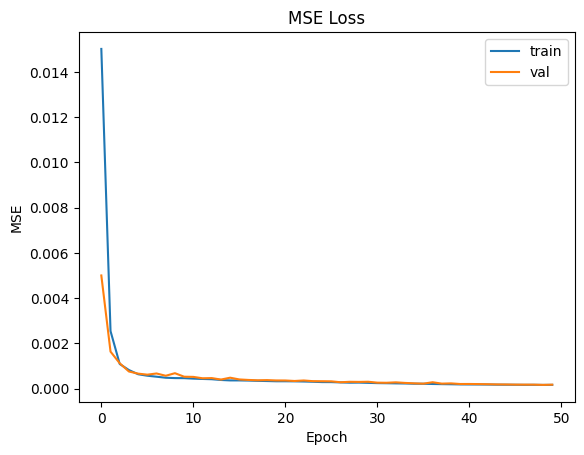

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_hist, label="train")
plt.plot(val_hist, label="val")
plt.title("MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [38]:
# en iyi modeli yükle
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

def predict_all(model, loader):
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)
            pred = model(Xb).cpu().numpy().reshape(-1)
            true = yb.numpy().reshape(-1)
            preds.append(pred)
            trues.append(true)
    return np.concatenate(preds), np.concatenate(trues)

pred_scaled, true_scaled = predict_all(model, test_loader)

# ölçek geri al
pred = scaler.inverse_transform(pred_scaled)
true = scaler.inverse_transform(true_scaled)

mae = float(np.mean(np.abs(pred - true)))
rmse = float(np.sqrt(np.mean((pred - true)**2)))
mape = float(np.mean(np.abs((pred - true) / (true + 1e-8))) * 100)

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE : 406.2179
RMSE: 560.2155
MAPE: 1.12%


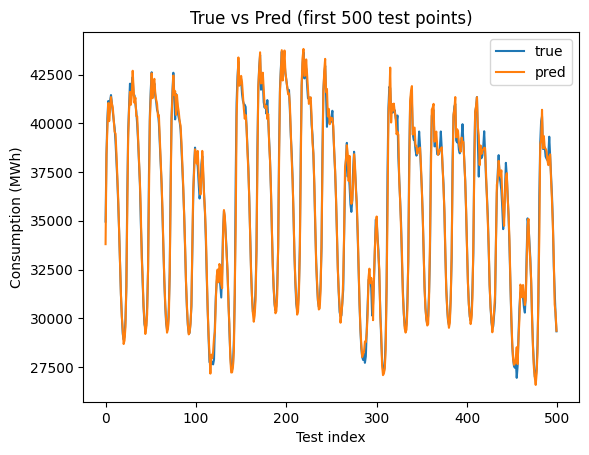

In [39]:
plt.figure()
plt.plot(true[:500], label="true")
plt.plot(pred[:500], label="pred")
plt.title("True vs Pred (first 500 test points)")
plt.xlabel("Test index")
plt.ylabel("Consumption (MWh)")
plt.legend()
plt.show()


In [40]:
import pandas as pd

history_df = pd.DataFrame({
    "epoch": list(range(1, len(train_hist)+1)),
    "train_mse": train_hist,
    "val_mse": val_hist
})

display(history_df.head(10))
display(history_df.tail(10))

best_epoch = int(history_df["val_mse"].idxmin()) + 1
best_val_mse = float(history_df["val_mse"].min())
print("Best epoch:", best_epoch)
print("Best val MSE:", best_val_mse)


,epoch,train_mse,val_mse
0,1,0.015010,0.005002
1,2,0.002544,0.001638
2,3,0.001090,0.001122
3,4,0.000823,0.000759
4,5,0.000638,0.000665
5,6,0.000572,0.000619
6,7,0.000529,0.000671
7,8,0.000483,0.000571
8,9,0.000468,0.000684
9,10,0.000465,0.000529


,epoch,train_mse,val_mse
40,41,0.000186,0.000207
41,42,0.000185,0.000203
42,43,0.000182,0.000196
43,44,0.000176,0.000188
44,45,0.000175,0.000185
45,46,0.000172,0.000179
46,47,0.000169,0.000179
47,48,0.000170,0.000178
48,49,0.000166,0.000168
49,50,0.000169,0.000177


Best epoch: 49
Best val MSE: 0.00016752285826500627


In [41]:
history_df.to_csv("training_history.csv", index=False)
print("Saved: training_history.csv")


Saved: training_history.csv


In [42]:
# Naive baseline: tahmin = pencerenin son değeri
naive_scaled = X_test[:, -1]             # (7864,)
true_scaled2 = y_test                     # (7864,)

naive = scaler.inverse_transform(naive_scaled)
true2  = scaler.inverse_transform(true_scaled2)

mae_n = float(np.mean(np.abs(naive - true2)))
rmse_n = float(np.sqrt(np.mean((naive - true2)**2)))
mape_n = float(np.mean(np.abs((naive - true2) / (true2 + 1e-8))) * 100)

print("Naive Baseline Metrics")
print(f"MAE : {mae_n:.4f}")
print(f"RMSE: {rmse_n:.4f}")
print(f"MAPE: {mape_n:.2f}%")

print("\nLSTM vs Naive (lower is better)")
print(f"MAE : {mae:.4f}  vs  {mae_n:.4f}")
print(f"RMSE: {rmse:.4f}  vs  {rmse_n:.4f}")
print(f"MAPE: {mape:.2f}%  vs  {mape_n:.2f}%")


Naive Baseline Metrics
MAE : 1152.5505
RMSE: 1527.3179
MAPE: 3.14%

LSTM vs Naive (lower is better)
MAE : 406.2179  vs  1152.5505
RMSE: 560.2155  vs  1527.3179
MAPE: 1.12%  vs  3.14%


In [43]:
results = pd.DataFrame([
    {"Model": "Naive (tahmin = son değer)", "MAE": mae_n, "RMSE": rmse_n, "MAPE(%)": mape_n},
    {"Model": "LSTM (SEQ_LEN=24)",         "MAE": mae,   "RMSE": rmse,   "MAPE(%)": mape},
])

display(results)
results.to_csv("results_table.csv", index=False)
print("Saved: results_table.csv")


,Model,MAE,RMSE,MAPE(%)
0,Naive (tahmin = son değer),1152.550537,1527.317871,3.142508
1,LSTM (SEQ_LEN=24),406.217896,560.215454,1.116798


Saved: results_table.csv


TypeError: unhashable type: 'numpy.ndarray'

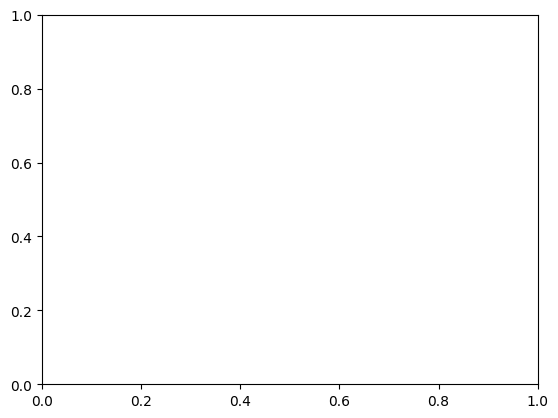

In [44]:
# Test dönemi zaman indeksini çıkar (SEQ_LEN kayması var)
test_times = df["time"].iloc[val_end + SEQ_LEN : val_end + SEQ_LEN + len(true)].reset_index(drop=True)

plt.figure()
plt.plot(test_times[:300], true[:300], label="true")
plt.plot(test_times[:300], pred[:300], label="pred")
plt.title("True vs Pred (first 300 points with time axis)")
plt.xlabel("Time")
plt.ylabel("Consumption (MWh)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
